# Libraries

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split


#Normalización
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

#models
from keras.models import Sequential
from keras.layers import Dense, LSTM
import xgboost as xgb
from sklearn.svm import SVC
from sklearn.neural_network import MLPRegressor
import tensorflow as tf
from tensorflow.keras.layers import Layer, Input, Dense, LSTM
from tensorflow.keras.models import Model
#metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


# Importing data

In [15]:

df = pd.read_csv('Datos.csv')


In [16]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2514 entries, 0 to 2513
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Nro         2514 non-null   int64  
 1   IGBVL       2514 non-null   float64
 2   GOLD        2510 non-null   float64
 3   WTI         2511 non-null   float64
 4   Cooper      2514 non-null   float64
 5   USD         2511 non-null   float64
 6   Corn        2514 non-null   float64
 7   Sugar       2514 non-null   float64
 8   FED         2514 non-null   float64
 9   SoyBean     2514 non-null   float64
 10  Wheat       2514 non-null   float64
 11  Dow         2514 non-null   float64
 12  TC          2514 non-null   float64
 13  Elecciones  2514 non-null   int64  
 14  Impuesto    2514 non-null   int64  
 15  Dir         2514 non-null   object 
dtypes: float64(12), int64(3), object(1)
memory usage: 314.4+ KB


In [17]:
df.head()

,Nro,IGBVL,GOLD,WTI,Cooper,USD,Corn,Sugar,FED,SoyBean,Wheat,Dow,TC,Elecciones,Impuesto,Dir
0,1,20997.56,1562.6,86.53,3.37,79.871002,6.435,0.1942,0.09,0.4920,6.2475,12393.45,2.7075,0,1,A
1,2,20700.68,1620.5,83.23,3.31,79.947998,6.520,0.1909,0.09,0.4859,6.4175,12118.57,2.7075,0,1,D
2,3,20575.03,1612.2,83.98,3.31,80.514999,6.520,0.1890,0.10,0.4831,6.3975,12101.46,2.7075,0,1,D
3,4,20655.57,1615.2,84.29,3.29,80.610001,6.515,0.1906,0.10,0.4850,6.4100,12127.95,2.6940,0,1,A
4,5,21018.91,1632.8,85.02,3.38,80.369003,6.115,0.1990,0.10,0.4925,6.0500,12414.79,2.6860,0,1,A


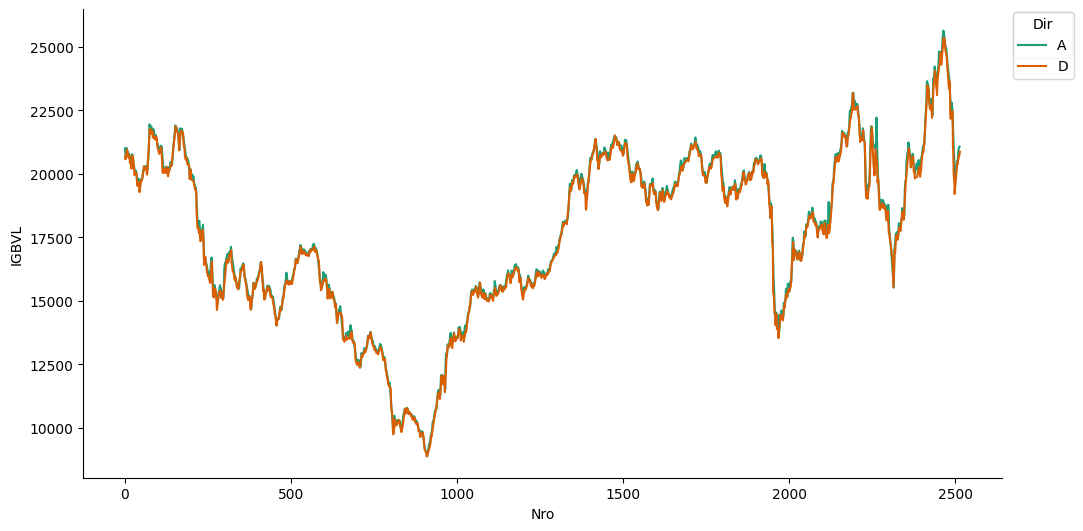

In [18]:
# @title IGBVL over time

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['Nro']
  ys = series['IGBVL']

  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = df.sort_values('Nro', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('Dir')):
  _plot_series(series, series_name, i)
  fig.legend(title='Dir', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Nro')
_ = plt.ylabel('IGBVL')

# Funciones auxiliares

In [19]:
def graficar_predicciones(real, prediccion):
    plt.plot(real[0:len(prediccion)],color='red', label='Valor real de Indice')
    plt.plot(prediccion, color='blue', label='Predicción del Indice')
    plt.ylim(1.1 * np.min(prediccion)/2, 1.1 * np.max(prediccion))
    plt.xlabel('Tiempo')
    plt.ylabel('Valor del Indice')
    plt.legend()
    plt.show()
def mse (actual, pred):
  actual, pred = np.array (actual), np.array (pred)
  return np.square (np.subtract (actual, pred)). mean ()


# Train and Test dataset

In [20]:
set_entrenamiento = df[:1750].iloc[:,1:2]
set_validacion = df[1751:].iloc[:,1:2]


In [21]:
set_entrenamiento

,IGBVL
0,20997.56
1,20700.68
2,20575.03
3,20655.57
4,21018.91
...,...
1745,20074.22
1746,19902.59
1747,19669.22
1748,19711.53


In [22]:
# Normalización del set de entrenamiento
sc = MinMaxScaler(feature_range=(0,1))
set_entrenamiento_escalado = sc.fit_transform(set_entrenamiento)

In [51]:
time_step = 250
X_train = []
Y_train = []
# Tamaño del dataset de entrenamento
m = len(set_entrenamiento_escalado)

for i in range(time_step,m):
    # X: bloques de "time_step" datos: 0-time_step, 1-time_step+1, 2-time_step+2, etc (días de 1 a 60)
    X_train.append(set_entrenamiento_escalado[i-time_step:i,0])
    # Y: el siguiente dato (día 61)
    Y_train.append(set_entrenamiento_escalado[i,0])

X_train, Y_train = np.array(X_train), np.array(Y_train)
print("Dimensión de X_train", X_train.shape, np.array(X_train).shape)
print("Dimensión de Y_train", np.array(Y_train).shape)
print(Y_train)
# Reshape X_train para que se ajuste al modelo en Keras
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

Dimensión de X_train (1500, 250) (1500, 250)
Dimensión de Y_train (1500,)
[0.54251797 0.54958409 0.54166816 ... 0.82540606 0.82864235 0.82538082]


# Model: Neural Network LSTM

In [58]:
# Parámetros
epochs = 60
batch_size=300
dim_entrada = (X_train.shape[1],1)
dim_salida = 1
na = 50
print(X_train.shape)
modelo = Sequential()
modelo.add(LSTM(units=na, input_shape=dim_entrada))
modelo.add(Dense(units=dim_salida))
modelo.compile(optimizer='rmsprop', loss='mse')
modelo.fit(X_train,Y_train,batch_size, epochs)

(1500, 250, 1)
Epoch 1/60
5/5 [==============================] - 7s 380ms/step - loss: 0.1688
Epoch 2/60
5/5 [==============================] - 2s 377ms/step - loss: 0.0038
Epoch 3/60
5/5 [==============================] - 3s 661ms/step - loss: 0.0027
Epoch 4/60
5/5 [==============================] - 3s 507ms/step - loss: 0.0027
Epoch 5/60
5/5 [==============================] - 2s 380ms/step - loss: 0.0058
Epoch 6/60
5/5 [==============================] - 2s 380ms/step - loss: 0.0042
Epoch 7/60
5/5 [==============================] - 2s 377ms/step - loss: 0.0029
Epoch 8/60
5/5 [==============================] - 2s 379ms/step - loss: 0.0045
Epoch 9/60
5/5 [==============================] - 2s 460ms/step - loss: 0.0027
Epoch 10/60
5/5 [==============================] - 3s 684ms/step - loss: 0.0036
Epoch 11/60
5/5 [==============================] - 2s 374ms/step - loss: 0.0026
Epoch 12/60
5/5 [==============================] - 2s 380ms/step - loss: 0.0032
Epoch 13/60
5/5 [=================

## Evaluating model

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


Dimensión de X_test (513, 250) (513, 250)
Dimensión de X_test (513, 250)
Dimensión de X_test (513, 250)
17/17 [==============================] - 1s 30ms/step


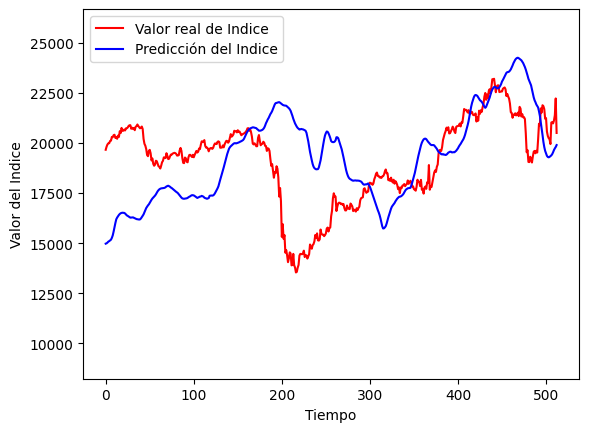

In [59]:
x_test = set_validacion.values
x_test = sc.transform(x_test)

X_test = []
for i in range(time_step,len(x_test)):
    X_test.append(x_test[i-time_step:i,0])
X_test = np.array(X_test)
print("Dimensión de X_test",X_test.shape,(X_test.shape[0],X_test.shape[1]))
print("Dimensión de X_test",(X_test.shape[0],X_test.shape[1]))
#X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1]),1)

print("Dimensión de X_test",X_test.shape)

prediccion = modelo.predict(X_test)


prediccion = sc.inverse_transform(prediccion)

# Graficar resultados
graficar_predicciones(set_validacion.values,prediccion)


In [60]:
prediccion[500]

array([19478.705], dtype=float32)

In [61]:
set_validacion.values[500]

array([21236.33])

In [62]:
actual=set_validacion.values[:500]
pred = prediccion[:500]

mse = mean_squared_error(actual, pred)
mae = mean_absolute_error(actual, pred)
r2 = r2_score(actual, pred)

print(f'Mean Squared Error: {mse}')
print(f'Mean Absolute Error: {mae}')
print(f'R^2 Score: {r2}')

Mean Squared Error: 8117169.346856931
Mean Absolute Error: 2222.62383625
R^2 Score: -0.793521404713114


# LSTM v2 (Hyperparameters v2)


In [43]:
# Parámetros
epochs = 100
batch_size= 25
dim_entrada = (X_train.shape[1],1)
dim_salida = 1
na = 50
print(X_train.shape)
modelo1 = Sequential()
modelo1.add(LSTM(units=na, input_shape=dim_entrada))
modelo1.add(Dense(units=dim_salida))
modelo1.compile(optimizer='rmsprop', loss='mse')
modelo1.fit(X_train,Y_train,batch_size, epochs)

(1690, 60, 1)
Epoch 1/100
68/68 [==============================] - 4s 27ms/step - loss: 0.0154
Epoch 2/100
68/68 [==============================] - 3s 38ms/step - loss: 0.0024
Epoch 3/100
68/68 [==============================] - 2s 34ms/step - loss: 0.0018
Epoch 4/100
68/68 [==============================] - 2s 25ms/step - loss: 0.0015
Epoch 5/100
68/68 [==============================] - 2s 25ms/step - loss: 0.0011
Epoch 6/100
68/68 [==============================] - 2s 25ms/step - loss: 0.0010
Epoch 7/100
68/68 [==============================] - 2s 25ms/step - loss: 9.4910e-04
Epoch 8/100
68/68 [==============================] - 2s 25ms/step - loss: 8.2425e-04
Epoch 9/100
68/68 [==============================] - 2s 33ms/step - loss: 7.9515e-04
Epoch 10/100
68/68 [==============================] - 3s 38ms/step - loss: 7.4273e-04
Epoch 11/100
68/68 [==============================] - 2s 27ms/step - loss: 6.7285e-04
Epoch 12/100
68/68 [==============================] - 2s 25ms/step - loss

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


Dimensión de X_test (703, 60) (703, 60)
Dimensión de X_test (703, 60)
Dimensión de X_test (703, 60)
22/22 [==============================] - 1s 10ms/step


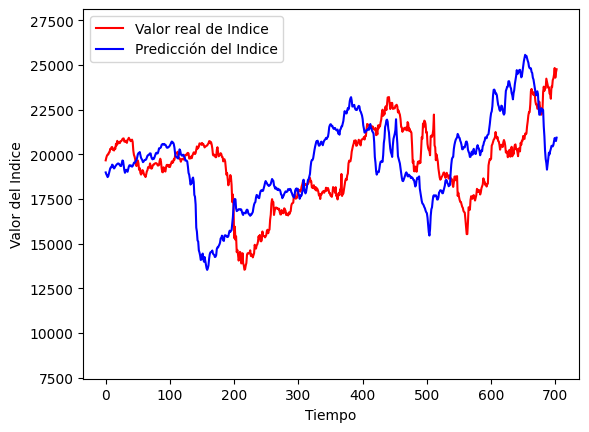

In [44]:
x_test = set_validacion.values
x_test = sc.transform(x_test)

X_test = []
for i in range(time_step,len(x_test)):
    X_test.append(x_test[i-time_step:i,0])
X_test = np.array(X_test)
print("Dimensión de X_test",X_test.shape,(X_test.shape[0],X_test.shape[1]))
print("Dimensión de X_test",(X_test.shape[0],X_test.shape[1]))
#X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1]),1)

print("Dimensión de X_test",X_test.shape)

prediccion = modelo1.predict(X_test)


prediccion = sc.inverse_transform(prediccion)

# Graficar resultados
graficar_predicciones(set_validacion.values,prediccion)

In [45]:
actual=set_validacion.values[:500]
pred = prediccion[:500]

mse = mean_squared_error(actual, pred)
mae = mean_absolute_error(actual, pred)
r2 = r2_score(actual, pred)

print(f'Mean Squared Error: {mse}')
print(f'Mean Absolute Error: {mae}')
print(f'R^2 Score: {r2}')

Mean Squared Error: 6758232.792287031
Mean Absolute Error: 2068.4304075
R^2 Score: -0.49325887548401126


# LSTM with Attention Mechanism

In [35]:
# Definir el mecanismo de atención
class Attention(Layer):
    def __init__(self, **kwargs):
        super(Attention, self).__init__(**kwargs)

    def build(self, input_shape):
        self.W = self.add_weight(name="att_weight", shape=(input_shape[-1], input_shape[-1]), initializer="glorot_uniform", trainable=True)
        self.b = self.add_weight(name="att_bias", shape=(input_shape[-1],), initializer="zeros", trainable=True)
        super(Attention, self).build(input_shape)

    def call(self, x):
        e = tf.nn.tanh(tf.tensordot(x, self.W, axes=1) + self.b)
        a = tf.nn.softmax(e, axis=1)
        output = tf.reduce_sum(x * a, axis=1)
        return output

In [36]:
sc = MinMaxScaler(feature_range=(0,1))
set_entrenamiento = df[:1750].iloc[:,1:2]
set_validacion = df[1751:].iloc[:,1:2]
set_entrenamiento_escalado = sc.fit_transform(set_entrenamiento)

In [37]:
# Crear secuencias de entrenamiento
time_step = 60
X_train, Y_train = [], []
for i in range(time_step, len(set_entrenamiento_escalado)):
    X_train.append(set_entrenamiento_escalado[i-time_step:i, 0])
    Y_train.append(set_entrenamiento_escalado[i, 0])
X_train, Y_train = np.array(X_train), np.array(Y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

In [38]:
# Definir el modelo LSTM con atención
inputs = Input(shape=(time_step, 1))
lstm_out = LSTM(units=50, return_sequences=True)(inputs)
attention_out = Attention()(lstm_out)
outputs = Dense(1)(attention_out)
model = Model(inputs=inputs, outputs=outputs)
model.compile(optimizer='rmsprop', loss='mse')
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 60, 1)]           0         
                                                                 
 lstm_4 (LSTM)               (None, 60, 50)            10400     
                                                                 
 attention (Attention)       (None, 50)                2550      
                                                                 
 dense_4 (Dense)             (None, 1)                 51        
                                                                 
Total params: 13001 (50.79 KB)
Trainable params: 13001 (50.79 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [39]:
# Entrenar el modelo
model.fit(X_train, Y_train, epochs=50, batch_size=10)

Epoch 1/50
169/169 [==============================] - 6s 27ms/step - loss: 0.0107
Epoch 2/50
169/169 [==============================] - 4s 23ms/step - loss: 0.0061
Epoch 3/50
169/169 [==============================] - 4s 26ms/step - loss: 0.0059
Epoch 4/50
169/169 [==============================] - 4s 23ms/step - loss: 0.0056
Epoch 5/50
169/169 [==============================] - 5s 27ms/step - loss: 0.0055
Epoch 6/50
169/169 [==============================] - 4s 21ms/step - loss: 0.0053
Epoch 7/50
169/169 [==============================] - 4s 21ms/step - loss: 0.0052
Epoch 8/50
169/169 [==============================] - 4s 26ms/step - loss: 0.0050
Epoch 9/50
169/169 [==============================] - 4s 24ms/step - loss: 0.0048
Epoch 10/50
169/169 [==============================] - 4s 21ms/step - loss: 0.0047
Epoch 11/50
169/169 [==============================] - 4s 21ms/step - loss: 0.0044
Epoch 12/50
169/169 [==============================] - 5s 28ms/step - loss: 0.0044
Epoch 13/50
1

In [40]:
# Preparar datos de validación y realizar predicciones
x_test = set_validacion.values
x_test = sc.transform(x_test)
X_test = []
for i in range(time_step, len(x_test)):
    X_test.append(x_test[i-time_step:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
prediccion = model.predict(X_test)
prediccion = sc.inverse_transform(prediccion)


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


22/22 [==============================] - 1s 12ms/step


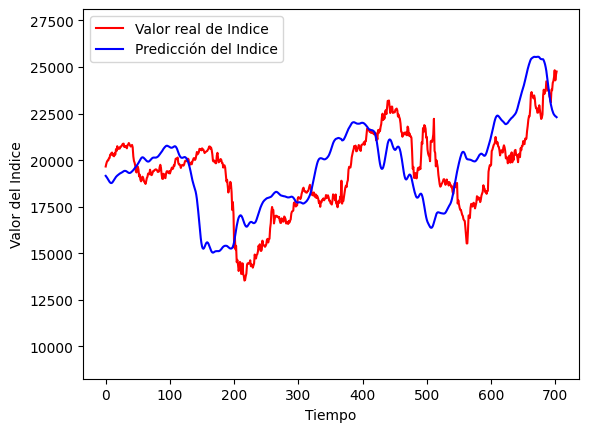

In [41]:
# Graficar los resultados
graficar_predicciones(set_validacion.values, prediccion)

In [42]:
# Calcular métricas de evaluación
actual = set_validacion.values[:500]
pred = prediccion[:500]
mse = mean_squared_error(actual, pred)
mae = mean_absolute_error(actual, pred)
r2 = r2_score(actual, pred)
print(f'Mean Squared Error: {mse}')
print(f'Mean Absolute Error: {mae}')
print(f'R^2 Score: {r2}')

Mean Squared Error: 4982730.645231007
Mean Absolute Error: 1823.945508515625
R^2 Score: -0.10095449340380847
